In [5]:
import pandas as pd
import os, gzip
import seaborn as sn
import matplotlib.pyplot as plt

datapath = "/lustrehome/pietrolucamazzacuva/ROC-AUC_files_HEK2937_Pecori/RDDpred_v1.0.Dir/OutDir"

df = pd.read_table(f"{datapath}/Test.RDDpred.results_report.txt")
data = df[((df.iloc[:, 2] == "A") & (df.iloc[:, 3] == "G")) | ((df.iloc[:, 2] == "T") & (df.iloc[:, 3] == "C"))]
print(data.loc[:, "Predicted_As"].value_counts())

Predicted_As
Artefact        1695037
True_Editing     895542
Name: count, dtype: int64


In [6]:
data.reset_index(drop=True, inplace=True)
data =data.loc[:, ["Chromosome", "One_based_Position", "Reference_Base", "Variant_Base", "Predicted_As"]]
data.columns = ["Region", "Position", "Reference_Base", "Variant_Base", "RDDpred_Predicted_Class"]
index = data[data.loc[:, "RDDpred_Predicted_Class"]=="True_Editing"].index.tolist()
data.iloc[index, 4] = 1
index = data[data.loc[:, "RDDpred_Predicted_Class"]=="Artefact"].index.tolist()
data.iloc[index, 4] = 0
print(data.loc[:, "RDDpred_Predicted_Class"].value_counts())

RDDpred_Predicted_Class
0    1695037
1     895542
Name: count, dtype: int64


In [19]:
def return_class(x):
    if x > 0.5:
        predictedclass = 1
    else:
        predictedclass = 0
    return predictedclass

sitespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T"

tables = [["outTable_599710609", "outTable_905657585"], 
          ["outTable_572868058", "outTable_364841872"],
          ["outTable_110067244", "outTable_597789462"]]

siteslists = []

for i in range(3):
    
    sites = pd.read_table(os.path.join(sitespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"), usecols=["Region", "Position", "Class"])
    sites.columns = ["Region", "Position", "Real_Class"]
    wt = pd.read_table(os.path.join(sitespath, tables[i][0]+"_predictions.tsv"), usecols=["Region", "Position", "Strand", "Editing_Probability"]) 
    sites = sites.merge(wt, how="inner", on=["Region", "Position"])
    sites.loc[:, f"REDInet_Predicted_Class_{tables[i][0]}"] = sites.loc[:, "Editing_Probability"].apply(return_class)
    sites = sites.loc[:, ["Region", "Position", "Strand", "Real_Class", f"REDInet_Predicted_Class_{tables[i][0]}"]]
    sites = sites[sites.loc[:, "Real_Class"]==1]
    siteslists.append(sites)

    

In [26]:
siteslists = []

for i in range(3):
    
    sites = pd.read_table(os.path.join(sitespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"), usecols=["Region", "Position", "Class"])
    sites.columns = ["Region", "Position", "Real_Class"]
    wt = pd.read_table(os.path.join(sitespath, tables[i][0]+"_predictions.tsv"), usecols=["Region", "Position", "Strand", "Editing_Probability"]) 
    sites = sites.merge(wt, how="inner", on=["Region", "Position"])
    sites.loc[:, "REDInet_Predicted_Class"] = sites.loc[:, "Editing_Probability"].apply(return_class)
    sites = sites.loc[:, ["Region", "Position", "Strand", "Real_Class", "REDInet_Predicted_Class"]]
    sites = sites[sites.loc[:, "Real_Class"]==1]
    sites = sites.merge(data.loc[:, ["Region", "Position","RDDpred_Predicted_Class"]], how="inner", on=["Region", "Position"])
    siteslists.append(sites)

for df in siteslists:
    print(df.loc[:, "REDInet_Predicted_Class"].value_counts())
    print(df.loc[:, "RDDpred_Predicted_Class"].value_counts())

REDInet_Predicted_Class
1    8159
0     186
Name: count, dtype: int64
RDDpred_Predicted_Class
1    7777
0     568
Name: count, dtype: int64
REDInet_Predicted_Class
1    6603
0     128
Name: count, dtype: int64
RDDpred_Predicted_Class
1    6291
0     440
Name: count, dtype: int64
REDInet_Predicted_Class
1    5260
0      85
Name: count, dtype: int64
RDDpred_Predicted_Class
1    4423
0     922
Name: count, dtype: int64


In [32]:
falsenegativerate = []

for i in range(3):
    countsredi =  (siteslists[i].loc[:, "REDInet_Predicted_Class"].value_counts()/df.shape[0])[0]
    falsenegativerate.append([countsredi, f"WT{i+1}", "REDInet"])
    
for i in range(3):
    countsredi =  (siteslists[i].loc[:, "RDDpred_Predicted_Class"].value_counts()/df.shape[0])[0]
    falsenegativerate.append([countsredi, f"WT{i+1}", "RDDpred"])

falsenegativerate = pd.DataFrame(falsenegativerate, columns=["False Negative Rate", "Sample", "Classifier"])

falsenegativerate

,False Negative Rate,Sample,Classifier
0,0.022289,WT1,REDInet
1,0.015339,WT2,REDInet
2,0.010186,WT3,REDInet
3,0.068065,WT1,RDDpred
4,0.052726,WT2,RDDpred
5,0.110485,WT3,RDDpred


In [33]:
falsenegativerate.groupby("Classifier").describe()

False Negative Rate                                          \
                         count      mean       std       min       25%   
Classifier                                                               
RDDpred                    3.0  0.077092  0.029919  0.052726  0.060395   
REDInet                    3.0  0.015938  0.006074  0.010186  0.012762   

                                          
                 50%       75%       max  
Classifier                                
RDDpred     0.068065  0.089275  0.110485  
REDInet     0.015339  0.018814  0.022289

/tmp/ipykernel_60774/1775615125.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(data=falsenegativerate, y="False Negative Rate", x="Classifier", palette=palette).set_title("HEK293T WT-Samples False Negative Rate")


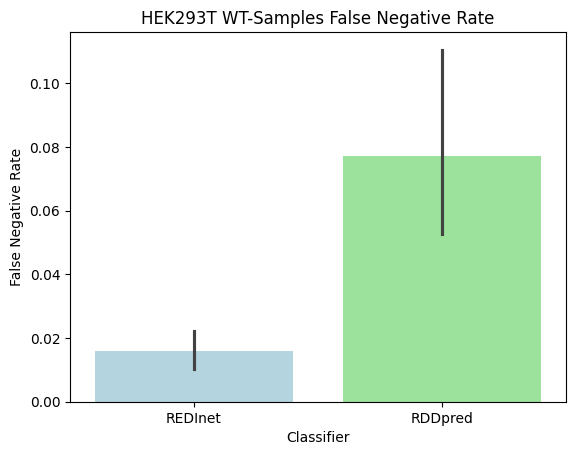

In [42]:
path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T"

fig, ax = plt.subplots()

palette=["lightblue", "lightgreen"]
sn.barplot(data=falsenegativerate, y="False Negative Rate", x="Classifier", palette=palette).set_title("HEK293T WT-Samples False Negative Rate")

plt.savefig(f"{path}/REDInet_RDDpred_false_negative_rate_barplot.tiff", dpi=300)

plt.show()